# Crime Prediction on Arabic Tweets and YouTube comments using Big Data Framework
## prepared by:
- Mohammad Awad
- Ahmad Abdelnabi
- Ibrahim Abedalghafer


# Loading libraries, starting the spark session and counting the label of the data

In [1]:
!pip install spark-nlp
!pip install aquirdturtle_collapsible_headings

In [2]:
import pandas as pd
import json
import numpy as np
import os

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
# autoBroadcastJoinThreshold to get rid of the warning message of serialize object
spark = SparkSession.\
        builder.\
        appName("bd-project").\
        master("spark://spark-master:7077").\
        config("spark.driver.memory","20G").\
        config("spark.executor.memory", "6144m").\
        config("spark.driver.maxResultSize", "0"). \
        config("spark.jars.ivy","/opt/workspace").\
        config("spark.serializer", "org.apache.spark.serializer.KryoSerializer").\
        config("spark.kryoserializer.buffer.max", "2000M").\
        config("spark.jsl.settings.pretrained.cache_folder", "/opt/workspace").\
        config("spark.jsl.settings.storage.cluster_tmp_dir", "/opt/workspace").\
        config("spark.jsl.settings.annotator.log_folder","/opt/workspace").\
        config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:4.2.6").\
        config('spark.sql.autoBroadcastJoinThreshold', "-1").\
        config('spark.logConf', 'true').\
        config('spark.logLevel', 'ERROR').\
        getOrCreate()

spark

Ivy Default Cache set to: /opt/workspace/cache
The jars for the packages stored in: /opt/workspace/jars
:: loading settings :: url = jar:file:/usr/local/lib/python3.9/dist-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-4e730832-b898-4374-9a0a-4790681106c3;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;4.2.6 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	

In [4]:
df = (spark.read
      .option("multiline", "true")
      .option("quote", '"')
      .option("header", "true")
      .option("escape", "\\")
      .option("escape", '"')
      .csv('new_labeled_data_v2.csv')
)
df.groupby('Label').count().show()

+-----+-----+
|Label|count|
+-----+-----+
|    N| 4821|
|    P|18461|
+-----+-----+



In [5]:
#df = df.withColumnRenamed('comments', 'text').withColumnRenamed('label','class')
df = df.withColumnRenamed('label','class')
df.printSchema()

root
 |-- comments: string (nullable = true)
 |-- class: string (nullable = true)



# Building stop word list to be used later and loading needed libraries, and creating all custom needed functions

In [6]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.sql import functions as F
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LinearSVC


!pip install nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stop_words_list1 = ["ال", "و", "في", "على", "من", "إلى", "مع", "عن", "كان", "هو", "يكون", "يمكن", "عشان", "أن", "ما", "كيف", "ليه", "كل", "نفس", "عدد", "كم", "كما", "أي", "متى", "منذ", "أ"]
# list.txt downloaded from https://github.com/mohataher/arabic-stop-words/blob/master/list.txt
!wget -qq https://raw.githubusercontent.com/mohataher/arabic-stop-words/master/list.txt
file1 = open('list.txt', 'r', encoding='utf-8') 
stopwords_arabic = file1.read().splitlines() + nltk.corpus.stopwords.words("arabic")
stopword_list = StopWordsCleaner.pretrained("stopwords_ar","ar").getStopWords()
stopword_list.append('ههههععع')
stopword_list.append('هع')
stopword_list.append('خ')
stopword_list.append('وما')
stopword_list.append('ما')
stopword_list.append('اذا')
stopword_list.append('إذا')
stopword_list.append('**')
stopword_list.append('اللة')
stopword_list.append('اى')
stopword_list.append('ولا')
stopword_list.append('...')
stopword_list.append('....')
stopword_list.append('. . . .')
stopword_list.append('_')
stopword_list.append('______________________')
stopword_list.append('___')
stopword_list.append('__')
stopword_list.append('_cr')
stopword_list.append('ءء')
stopword_list.append('ءءء')
stopword_list.append('ءن')
stopword_list.append('آآآآآآآآه')
stopword_list.append('آآآآآآآمين')
stopword_list.append('آآآهههههه')
stopword_list.append('آآلـه')
stopword_list.append('آآللهم')
stopword_list.append('آب')
stopword_list.append('آبائهم')
stopword_list.append(' ')
stopword_list.append('  ')
stopword_list.append('')

stopword_list.extend(stop_words_list1)
stopword_list.extend(stopwords_arabic)

stopwords_ar download started this may take some time.
Approximate size to download 1.9 KB
[ | ]stopwords_ar download started this may take some time.
Approximate size to download 1.9 KB
[ / ]Download done! Loading the resource.
[OK!]


In [8]:
def removeNumbers(text):
    from string import punctuation
    import re
    text1 =  ''.join(c for c in text if not c.isdigit())
    text2 =  ''.join(c for c in text1 if c not in punctuation)
    return re.sub(r'[^0-9\u0600-\u06ff\u0750-\u077f\ufb50-\ufbc1\ufbd3-\ufd3f\ufd50-\ufd8f\ufd50-\ufd8f\ufe70-\ufefc\uFDF0-\uFDFD.0-9]+', ' ', text2)

removeNumbersUDF = F.udf(removeNumbers)

In [9]:
#credit to https://python-programs.com/python-program-to-remove-adjacent-duplicate-characters-from-a-string/
def remAdj(list_of_words):
    # convert the given string to list using list() function
    output_list = []
    for givenstrng in list_of_words:
        charslist = list(givenstrng)
        prevele = None
        p = 0
        # Traverse the given string
        for chars in givenstrng:
            if prevele != chars:
                charslist[p] = chars
                prevele = chars
                p = p + 1
        # join the list which contains characters to string using join function and return it
        output_list.append(''.join(charslist[:p]))
    return output_list

remAdjUDF = F.udf(remAdj)

In [10]:
def fixingImbanace(df):
    # splitting the data training and testing, and on the train data ensure to use under sampling of the majority sample to avoid imbalance bais
    splits_P = df.filter(F.col('class') == 'P').randomSplit([0.7, 0.3], 1234)
    splits_N = df.filter(F.col('class') == 'N').randomSplit([0.7, 0.3], 1234)
    # Combine the two DataFrames
    training_data = splits_P[0].union(splits_N[0])
    testing_data = splits_P[1].union(splits_N[1])

    # Shuffle the rows on the combined DataFrame
    temp_split_train = training_data.randomSplit([0.5,0.5], 42)
    training_data = temp_split_train[0].union(temp_split_train[1])

    temp_split_test = testing_data.randomSplit([0.5,0.5], 42)
    testing_data = temp_split_test[0].union(temp_split_test[1])
    
    training_data.groupby('class').count().show()
    print(f"training data after the splitting has above values")
    testing_data.groupby('class').count().show()
    print(f"testing data after the splitting has: values")
    
    # doing under sampling in the training data (fraction is calculated by dividing the #of_N / #_of_P)
    training_data_N = training_data.filter(F.col('class') == 'N')
    training_data_P = training_data.filter(F.col('class') == 'P').sample(withReplacement=False, fraction=0.26, seed=42)

    training_data_balanced = training_data_N.union(training_data_P)
    temp_split_train_b = training_data_balanced.randomSplit([0.5,0.5], 42)
    training_data_balanced = temp_split_train_b[0].union(temp_split_train_b[1])
    training_data_balanced.groupby('class').count().show()
    print(f"balanced training data has values")
    return training_data_balanced, testing_data

In [11]:
documentAssembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")\
    .setCleanupMode("shrink")

tokenizer = Tokenizer() \
 .setInputCols(["document"]) \
 .setOutputCol("token")

stop_words = StopWordsCleaner.pretrained("stopwords_ar", "ar")\
        .setInputCols(["token"]) \
        .setOutputCol("cleanTokens")\
        .setCaseSensitive(False)\
        .setStopWords(stopword_list)

lemmatizer = LemmatizerModel.pretrained("lemma_padt", "ar") \
        .setInputCols(["cleanTokens"]) \
        .setOutputCol("lemma")

stop_words2 = StopWordsCleaner.pretrained("stopwords_ar", "ar")\
        .setInputCols(["lemma"]) \
        .setOutputCol("finalOutput")\
        .setCaseSensitive(False)\
        .setStopWords(stopword_list)


stopwords_ar download started this may take some time.
Approximate size to download 1.9 KB
[OK!]
lemma_padt download started this may take some time.
Approximate size to download 449.6 KB
[ | ]lemma_padt download started this may take some time.
Approximate size to download 449.6 KB
[ / ]Download done! Loading the resource.
[OK!]
stopwords_ar download started this may take some time.
Approximate size to download 1.9 KB
[OK!]


In [12]:
hashingTF = HashingTF(inputCol='result', outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")
stringIndexer = StringIndexer(inputCol="class", outputCol="label", stringOrderType="frequencyDesc")


In [13]:
nb_1 = NaiveBayes(smoothing=1.0, modelType="multinomial")
nb_2 = NaiveBayes(smoothing=0.5, modelType="multinomial")
lr_1 = LogisticRegression(regParam=0.0)
lr_2 = LogisticRegression(regParam=0.1)
lr_3 = LogisticRegression(regParam=0.05)
rf = RandomForestClassifier()
svm_1 = LinearSVC(regParam=0.0)
svm_2 = LinearSVC(regParam=0.1)
svm_3 = LinearSVC(regParam=0.05)
#    nb_1:'Naive bayes with smoothing = 1.0',
#    nb_2:'Naive bayes with smoothing = 0.5',
#    lr_1:'LogisticRegression with regParam = 0.0',
#    lr_2:'LogisticRegression with regParam = 0.1',
#    lr_3:'LogisticRegression with regParam = 0.05',
#    ann_1:'Neural Network with layers [262144, 50, 20, 2]',
#    ann_2:'Neural Network with layers [262144, 100, 50, 2]',
#    ann_3:'Neural Network with layers [262144, 100, 50, 20, 2]',
models_dict = {
    svm_1:'SVM with regParam = 0.0',
    svm_2:'SVM with regParam = 0.1',
    svm_3:'SVM with regParam = 0.05',
    nb_1:'Naive bayes with smoothing = 1.0',
    nb_2:'Naive bayes with smoothing = 0.5',
    lr_1:'LogisticRegression with regParam = 0.0',
    lr_2:'LogisticRegression with regParam = 0.1',
    lr_3:'LogisticRegression with regParam = 0.05',
    rf:'Random forst classifier'
}

In [84]:
def trainModels(models_dict, training_data, testing_data):
    results = {}
    result_df = []
    for model in list(models_dict.keys()):
        print(f'working with model {models_dict[model]}')
        estrimator = model.fit(training_data)
        predictions = estrimator.transform(testing_data)
        
        print('Done training, and testing, below are the results')
        evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",metricName="accuracy")
        evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
        accuracy = evaluator_acc.evaluate(predictions)
        f1 = evaluator_f1.evaluate(predictions)
        print("Test set accuracy = " + str(accuracy))
        print("Test set f1-score = " + str(f1))
        
        print('-'*60)
        results[models_dict[model]] = {'accuracy':accuracy, 'f1-score': f1}
        colName = 'prediction_'+(models_dict[model]).replace(' ','_')
        temp_df = predictions.select('label', 'prediction').withColumnRenamed('prediction','colName')
        result_df.append(temp_df)
        
        if f1 >= 0.80:
            print(f"saving model {(models_dict[model]).replace(' ','_')}")
            file_path = './'+(models_dict[model]).replace(' ','_')
            if not os.path.exists(file_path):
                model.save(file_path)
            else:
                print('Already there is a models saved')
           
        
    
    return results, result_df

In [15]:
# first split the text column by space 
df = df.withColumn("split_text",F.split(df["comments"]," "))
df = df.withColumn("cleaned_text", remAdjUDF("split_text"))
df = df.withColumn("cleaned_text_com",F.concat_ws(" ", "cleaned_text"))
df.select('cleaned_text_com').show(5, truncate=False)


+--------------------------------------------------------------------------------------------------------------+
|cleaned_text_com                                                                                              |
+--------------------------------------------------------------------------------------------------------------+
|[شمس, مثقفة, و, جميلة, وايد, ., و, احلام, هع, ما, اقول]                                                       |
|[احلام, اني, حبيتها, اكثر, لان, , انظلمت, كثير, من, الناس, , هي, امراه, قويه, وكبيره, في, عيونا, وليسه, محتشم]|
|[كبرلفك, واله, دايضحكون, عليج]                                                                                |
|[واله, كلامه, صحيح, عن, شمس]                                                                                  |
|[ذكرى, ما, نسيناك, وما, حد, بينسينا, صوتك, الجميل, وطيبتك, وقدراتك, الغير, موجوده, في, أي, بشر, رحمك, اله]    |
+-----------------------------------------------------------------------------------------------

In [16]:
df.printSchema()

root
 |-- comments: string (nullable = true)
 |-- class: string (nullable = true)
 |-- split_text: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- cleaned_text: string (nullable = true)
 |-- cleaned_text_com: string (nullable = false)



In [17]:
df = df.select('class', 'cleaned_text_com').withColumnRenamed('cleaned_text_com', 'comments')
df = df.select('class', removeNumbersUDF(F.col('comments')).alias('text'))
df.printSchema()
#df.show(30, truncate=False)

root
 |-- class: string (nullable = true)
 |-- text: string (nullable = true)



# Starting with pipeline #1 with lemmatization

In [18]:
pipeline = Pipeline(stages=[documentAssembler, tokenizer, stop_words, lemmatizer, stop_words2])
pipline2 = Pipeline(stages=[hashingTF, idf, stringIndexer])

In [19]:
df_1 = pipeline.fit(df).transform(df)
df_1 = df_1.select('class', 'finalOutput.result') # since this pipeline ends in stop_words2

In [20]:
training_data_balanced, testing_data = fixingImbanace(df_1)

+-----+-----+
|class|count|
+-----+-----+
|    N| 3417|
|    P|12956|
+-----+-----+

training data after the splitting has above values


+-----+-----+
|class|count|
+-----+-----+
|    N| 1404|
|    P| 5505|
+-----+-----+

testing data after the splitting has: values


+-----+-----+
|class|count|
+-----+-----+
|    N| 3417|
|    P| 3468|
+-----+-----+

balanced training data has values


In [21]:
prepare_training = pipline2.fit(training_data_balanced).transform(training_data_balanced)
prepare_testing = pipline2.fit(testing_data).transform(testing_data)
# P --> 0, and N --> 1 since it is less than in numbers

In [22]:
prepare_training = prepare_training.select('label', 'features')
prepare_testing = prepare_testing.select('label', 'features')

In [85]:
pipeline1_results, pipeline1_df = trainModels(models_dict, prepare_training, prepare_testing)

working with model SVM with regParam = 0.0


23/01/21 12:03:51 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:04:26 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:04:26 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:04:27 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:04:27 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:04:27 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:04:28 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:04:28 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:04:28 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:04:28 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:04:29 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:04:29 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 12:05:31 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
23/01/21 12:05:42 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


Test set accuracy = 0.8082211608047475
Test set f1-score = 0.8164782363688494
------------------------------------------------------------
saving model SVM_with_regParam_=_0.0
working with model SVM with regParam = 0.1


23/01/21 12:05:54 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:06:27 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:06:27 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:06:27 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:06:27 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:06:27 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:06:28 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:06:28 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:06:28 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:06:28 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:06:28 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:06:28 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 12:07:24 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
23/01/21 12:07:35 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


Test set accuracy = 0.7750759878419453
Test set f1-score = 0.7911754274130579
------------------------------------------------------------
working with model SVM with regParam = 0.05


23/01/21 12:07:46 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:08:18 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:08:18 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:08:18 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:08:18 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:08:18 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:08:19 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:08:19 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:08:19 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:08:19 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:08:19 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:08:19 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 12:09:10 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
23/01/21 12:09:21 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


Test set accuracy = 0.7869445650600666
Test set f1-score = 0.8003970561148073
------------------------------------------------------------
saving model SVM_with_regParam_=_0.05
working with model Naive bayes with smoothing = 1.0


23/01/21 12:09:32 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 12:10:05 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


Done training, and testing, below are the results


23/01/21 12:10:06 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/01/21 12:10:16 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


Test set accuracy = 0.7016934433347807
Test set f1-score = 0.7299865586329719
------------------------------------------------------------
working with model Naive bayes with smoothing = 0.5


23/01/21 12:10:28 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 12:11:01 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


Done training, and testing, below are the results


23/01/21 12:11:01 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/01/21 12:11:12 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


Test set accuracy = 0.6969170646982197
Test set f1-score = 0.7257342305059602
------------------------------------------------------------
working with model LogisticRegression with regParam = 0.0


23/01/21 12:11:22 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:11:54 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:11:55 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:11:55 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:11:55 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:11:55 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:11:55 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:11:55 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:11:55 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:11:56 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:11:56 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:11:56 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 12:12:25 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 12:12:35 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


Test set accuracy = 0.7325227963525835
Test set f1-score = 0.7546541148336631
------------------------------------------------------------
working with model LogisticRegression with regParam = 0.1


23/01/21 12:12:46 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:13:18 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:13:18 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:13:18 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:13:18 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:13:18 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:13:18 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:13:19 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:13:19 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:13:19 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:13:19 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:13:19 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 12:13:28 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 12:13:38 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


Test set accuracy = 0.7834708351425677
Test set f1-score = 0.7973952536903511
------------------------------------------------------------
working with model LogisticRegression with regParam = 0.05


23/01/21 12:13:49 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:14:20 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:14:21 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:14:21 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:14:21 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:14:21 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:14:21 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:14:21 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:14:21 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:14:21 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:14:22 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:14:22 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 12:14:33 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 12:14:44 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


Test set accuracy = 0.7881024750325663
Test set f1-score = 0.8008551099395407
------------------------------------------------------------
saving model LogisticRegression_with_regParam_=_0.05
working with model Random forst classifier


23/01/21 12:14:55 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:15:03 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:15:13 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 12:15:45 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
23/01/21 12:16:40 WARN DAGScheduler: Broadcasting large task binary with size 1032.7 KiB
23/01/21 12:16:40 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/01/21 12:17:23 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/01/21 12:17:28 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/01/21 12:17:33 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/01/21 12:17:38 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
23/01/21 12:17:42 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


Done training, and testing, below are the results


23/01/21 12:17:53 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


Test set accuracy = 0.8077869445650601
Test set f1-score = 0.7633804952358024
------------------------------------------------------------


In [86]:
pipeline1_results

{'SVM with regParam = 0.0': {'accuracy': 0.8082211608047475,
  'f1-score': 0.8164782363688494},
 'SVM with regParam = 0.1': {'accuracy': 0.7750759878419453,
  'f1-score': 0.7911754274130579},
 'SVM with regParam = 0.05': {'accuracy': 0.7869445650600666,
  'f1-score': 0.8003970561148073},
 'Naive bayes with smoothing = 1.0': {'accuracy': 0.7016934433347807,
  'f1-score': 0.7299865586329719},
 'Naive bayes with smoothing = 0.5': {'accuracy': 0.6969170646982197,
  'f1-score': 0.7257342305059602},
 'LogisticRegression with regParam = 0.0': {'accuracy': 0.7325227963525835,
  'f1-score': 0.7546541148336631},
 'LogisticRegression with regParam = 0.1': {'accuracy': 0.7834708351425677,
  'f1-score': 0.7973952536903511},
 'LogisticRegression with regParam = 0.05': {'accuracy': 0.7881024750325663,
  'f1-score': 0.8008551099395407},
 'Random forst classifier': {'accuracy': 0.8077869445650601,
  'f1-score': 0.7633804952358024}}

In [87]:
temp_var1 = json.dumps(pipeline1_results)
pipe1_results_df = pd.read_json(temp_var1)
pipe1_results_df.head()

,SVM with regParam = 0.0,SVM with regParam = 0.1,SVM with regParam = 0.05,Naive bayes with smoothing = 1.0,Naive bayes with smoothing = 0.5,LogisticRegression with regParam = 0.0,LogisticRegression with regParam = 0.1,LogisticRegression with regParam = 0.05,Random forst classifier
accuracy,0.808221,0.775076,0.786945,0.701693,0.696917,0.732523,0.783471,0.788102,0.807787
f1-score,0.816478,0.791175,0.800397,0.729987,0.725734,0.754654,0.797395,0.800855,0.763380


# Starting with pipeline2 without lemmatization

In [26]:
pipeline_2 = Pipeline(stages=[documentAssembler, tokenizer, stop_words])
pipline2_2 = Pipeline(stages=[hashingTF, idf, stringIndexer])

In [27]:
df_2 = pipeline_2.fit(df).transform(df)
df_2 = df_2.select('class', 'cleanTokens.result') # since this pipeline ends in stop_words

In [28]:
training_data_balanced_2, testing_data_2 = fixingImbanace(df_2)

+-----+-----+
|class|count|
+-----+-----+
|    N| 3417|
|    P|12956|
+-----+-----+

training data after the splitting has above values


+-----+-----+
|class|count|
+-----+-----+
|    N| 1404|
|    P| 5505|
+-----+-----+

testing data after the splitting has: values


+-----+-----+
|class|count|
+-----+-----+
|    N| 3417|
|    P| 3468|
+-----+-----+

balanced training data has values


In [29]:
prepare_training_2 = pipline2_2.fit(training_data_balanced_2).transform(training_data_balanced_2)
prepare_testing_2 = pipline2_2.fit(testing_data_2).transform(testing_data_2)
# P --> 0, and N --> 1 since it is less than in numbers

In [30]:
prepare_training_2 = prepare_training_2.select('label', 'features')
prepare_testing_2 = prepare_testing_2.select('label', 'features')

In [31]:
pipeline2_results, pipeline2_df = trainModels(models_dict, prepare_training_2, prepare_testing_2)

working with model SVM with regParam = 0.0


23/01/21 08:46:58 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:47:16 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:47:16 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:47:16 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:47:16 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:47:16 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:47:16 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:47:17 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:47:17 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:47:17 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:47:17 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:47:17 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 08:48:08 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
23/01/21 08:48:15 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


Test set accuracy = 0.8025763496888116
Test set f1-score = 0.8133767960771316
------------------------------------------------------------
working with model SVM with regParam = 0.1


23/01/21 08:48:21 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:48:40 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:48:40 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:48:40 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:48:40 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:48:40 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:48:40 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:48:40 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:48:41 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:48:41 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:48:41 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:48:41 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 08:49:33 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
23/01/21 08:49:39 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


Test set accuracy = 0.7659574468085106
Test set f1-score = 0.7836561632546329
------------------------------------------------------------
working with model SVM with regParam = 0.05


23/01/21 08:49:46 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:50:04 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:50:04 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:50:04 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:50:04 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:50:04 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:50:04 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:50:04 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:50:05 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:50:05 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:50:05 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:50:05 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 08:50:54 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
23/01/21 08:51:00 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


Test set accuracy = 0.7753654653350702
Test set f1-score = 0.7916405164202478
------------------------------------------------------------
working with model Naive bayes with smoothing = 1.0


23/01/21 08:51:07 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:51:25 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


Done training, and testing, below are the results


23/01/21 08:51:26 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/01/21 08:51:31 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


Test set accuracy = 0.6809958025763497
Test set f1-score = 0.7120340144958468
------------------------------------------------------------
working with model Naive bayes with smoothing = 0.5


23/01/21 08:51:38 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:51:56 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


Done training, and testing, below are the results


23/01/21 08:51:56 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/01/21 08:52:02 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


Test set accuracy = 0.6744825589810393
Test set f1-score = 0.7061870210418653
------------------------------------------------------------
working with model LogisticRegression with regParam = 0.0


23/01/21 08:52:09 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:52:27 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:52:27 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:52:27 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:52:27 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:52:27 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:52:28 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:52:28 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:52:28 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:52:28 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:52:28 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:52:28 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 08:52:56 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:53:02 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


Test set accuracy = 0.731075408886959
Test set f1-score = 0.7536810408561826
------------------------------------------------------------
working with model LogisticRegression with regParam = 0.1


23/01/21 08:53:09 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:53:27 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:53:27 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:53:27 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:53:28 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:53:28 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:53:28 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:53:28 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:53:28 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:53:28 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:53:28 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:53:28 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 08:53:37 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:53:43 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


Test set accuracy = 0.776233897814445
Test set f1-score = 0.7919240530533799
------------------------------------------------------------
working with model LogisticRegression with regParam = 0.05


23/01/21 08:53:50 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:54:08 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:54:08 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:54:08 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:54:08 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:54:08 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:54:09 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:54:09 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:54:09 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:54:09 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:54:09 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:54:09 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 08:54:21 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:54:27 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


Test set accuracy = 0.7763786365610074
Test set f1-score = 0.791708467126108
------------------------------------------------------------
working with model Random forst classifier


23/01/21 08:54:34 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:54:38 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:54:44 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 08:55:02 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
23/01/21 08:55:40 WARN DAGScheduler: Broadcasting large task binary with size 1032.7 KiB
23/01/21 08:55:40 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/01/21 08:56:10 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/01/21 08:56:14 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/01/21 08:56:17 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/01/21 08:56:21 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/01/21 08:56:24 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


Done training, and testing, below are the results


23/01/21 08:56:30 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


Test set accuracy = 0.7963525835866262
Test set f1-score = 0.748272875725637
------------------------------------------------------------


In [32]:
pipeline2_results

{'SVM with regParam = 0.0': {'accuracy': 0.8025763496888116,
  'f1-score': 0.8133767960771316},
 'SVM with regParam = 0.1': {'accuracy': 0.7659574468085106,
  'f1-score': 0.7836561632546329},
 'SVM with regParam = 0.05': {'accuracy': 0.7753654653350702,
  'f1-score': 0.7916405164202478},
 'Naive bayes with smoothing = 1.0': {'accuracy': 0.6809958025763497,
  'f1-score': 0.7120340144958468},
 'Naive bayes with smoothing = 0.5': {'accuracy': 0.6744825589810393,
  'f1-score': 0.7061870210418653},
 'LogisticRegression with regParam = 0.0': {'accuracy': 0.731075408886959,
  'f1-score': 0.7536810408561826},
 'LogisticRegression with regParam = 0.1': {'accuracy': 0.776233897814445,
  'f1-score': 0.7919240530533799},
 'LogisticRegression with regParam = 0.05': {'accuracy': 0.7763786365610074,
  'f1-score': 0.791708467126108},
 'Random forst classifier': {'accuracy': 0.7963525835866262,
  'f1-score': 0.748272875725637}}

In [33]:
temp_var2 = json.dumps(pipeline2_results)
pipe2_results_df = pd.read_json(temp_var2)
pipe2_results_df.head()

,SVM with regParam = 0.0,SVM with regParam = 0.1,SVM with regParam = 0.05,Naive bayes with smoothing = 1.0,Naive bayes with smoothing = 0.5,LogisticRegression with regParam = 0.0,LogisticRegression with regParam = 0.1,LogisticRegression with regParam = 0.05,Random forst classifier
accuracy,0.802576,0.765957,0.775365,0.680996,0.674483,0.731075,0.776234,0.776379,0.796353
f1-score,0.813377,0.783656,0.791641,0.712034,0.706187,0.753681,0.791924,0.791708,0.748273


# Starting with pipeline3 with lemmatization and N-gram=2

In [34]:
pipeline_3 = Pipeline(stages=[documentAssembler, tokenizer, stop_words, lemmatizer, stop_words2])
pipline2_3 = Pipeline(stages=[hashingTF, idf, stringIndexer])

In [35]:
from pyspark.ml.feature import NGram
ngram = NGram(n=2, inputCol="result", outputCol="ngrams")
df_3 = pipeline_3.fit(df).transform(df)
df_3 = df_3.select('class', 'finalOutput.result') # since this pipeline ends in stop_words2
df_3 = ngram.transform(df_3)
df_3.show(4, truncate=False)
df_3_n = df_3.select('class', 'ngrams').withColumnRenamed('ngrams', 'result')
df_3_n.show(4, truncate=False)

+-----+-------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------+
|class|result                                                                                     |ngrams                                                                                                                                                       |
+-----+-------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------+
|P    |[شَمس, مثقفة, جميلة, وايد, احلام, اقول]                                                    |[شَمس مثقفة, مثقفة جميلة, جميلة وايد, وايد احلام, احلام اقول]                                                                  

In [36]:
training_data_balanced_3, testing_data_3 = fixingImbanace(df_3_n)

+-----+-----+
|class|count|
+-----+-----+
|    N| 3417|
|    P|12956|
+-----+-----+

training data after the splitting has above values


+-----+-----+
|class|count|
+-----+-----+
|    N| 1404|
|    P| 5505|
+-----+-----+

testing data after the splitting has: values


+-----+-----+
|class|count|
+-----+-----+
|    N| 3417|
|    P| 3468|
+-----+-----+

balanced training data has values


In [37]:
prepare_training_3 = pipline2_3.fit(training_data_balanced_3).transform(training_data_balanced_3)
prepare_testing_3 = pipline2_3.fit(testing_data_3).transform(testing_data_3)
# P --> 0, and N --> 1 since it is less than in numbers

In [38]:
prepare_training_3 = prepare_training_3.select('label', 'features')
prepare_testing_3 = prepare_testing_3.select('label', 'features')

In [39]:
pipeline3_results, pipeline3_df = trainModels(models_dict, prepare_training_3, prepare_testing_3)

working with model SVM with regParam = 0.0


23/01/21 08:59:01 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 08:59:32 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 08:59:32 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 08:59:33 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 08:59:33 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 08:59:33 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 08:59:33 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 08:59:33 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 08:59:33 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 08:59:33 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 08:59:33 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 08:59:33 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 09:00:33 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
23/01/21 09:00:44 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


Test set accuracy = 0.7082066869300911
Test set f1-score = 0.7200135693511864
------------------------------------------------------------
working with model SVM with regParam = 0.1


23/01/21 09:00:55 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:01:28 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:01:28 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:01:28 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:01:28 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:01:28 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:01:28 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:01:29 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:01:29 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:01:29 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:01:29 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:01:29 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 09:02:25 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
23/01/21 09:02:36 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


Test set accuracy = 0.6647850629613548
Test set f1-score = 0.6898126628926902
------------------------------------------------------------
working with model SVM with regParam = 0.05


23/01/21 09:02:47 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:03:20 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:03:20 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:03:20 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:03:20 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:03:20 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:03:20 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:03:21 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:03:21 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:03:21 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:03:21 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:03:21 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 09:04:17 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
23/01/21 09:04:27 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


Test set accuracy = 0.6637718917354176
Test set f1-score = 0.6886844350669302
------------------------------------------------------------
working with model Naive bayes with smoothing = 1.0


23/01/21 09:04:38 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:05:09 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/01/21 09:05:10 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


Done training, and testing, below are the results


23/01/21 09:05:20 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


Test set accuracy = 0.6455348096685483
Test set f1-score = 0.6744158671116437
------------------------------------------------------------
working with model Naive bayes with smoothing = 0.5


23/01/21 09:05:32 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:06:03 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


Done training, and testing, below are the results


23/01/21 09:06:04 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/01/21 09:06:14 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


Test set accuracy = 0.646403242147923
Test set f1-score = 0.674883875250248
------------------------------------------------------------
working with model LogisticRegression with regParam = 0.0


23/01/21 09:06:25 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:06:57 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:06:57 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:06:57 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:06:57 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:06:58 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:06:58 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:06:58 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:06:58 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:06:58 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:06:58 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:06:58 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 09:07:13 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
23/01/21 09:07:23 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


Test set accuracy = 0.6449558546822984
Test set f1-score = 0.6745144340415145
------------------------------------------------------------
working with model LogisticRegression with regParam = 0.1


23/01/21 09:07:35 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:08:05 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:08:05 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:08:06 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:08:06 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:08:06 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:08:06 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:08:06 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:08:06 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:08:06 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:08:06 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:08:06 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 09:08:15 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
23/01/21 09:08:26 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


Test set accuracy = 0.7037197857866551
Test set f1-score = 0.716889761351115
------------------------------------------------------------
working with model LogisticRegression with regParam = 0.05


23/01/21 09:08:37 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:09:09 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:09:09 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:09:09 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:09:09 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:09:09 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:09:10 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:09:10 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:09:10 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:09:10 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:09:10 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:09:10 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 09:09:21 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
23/01/21 09:09:31 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


Test set accuracy = 0.7083514256766537
Test set f1-score = 0.7191533469081279
------------------------------------------------------------
working with model Random forst classifier


23/01/21 09:09:42 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:09:51 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:10:01 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 09:10:32 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
23/01/21 09:11:25 WARN DAGScheduler: Broadcasting large task binary with size 1032.7 KiB
23/01/21 09:11:26 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
23/01/21 09:12:10 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
23/01/21 09:12:15 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
23/01/21 09:12:19 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
23/01/21 09:12:23 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
23/01/21 09:12:27 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


Done training, and testing, below are the results


23/01/21 09:12:38 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


Test set accuracy = 0.7982341872919381
Test set f1-score = 0.7178353880676248
------------------------------------------------------------


In [40]:
pipeline3_results

{'SVM with regParam = 0.0': {'accuracy': 0.7082066869300911,
  'f1-score': 0.7200135693511864},
 'SVM with regParam = 0.1': {'accuracy': 0.6647850629613548,
  'f1-score': 0.6898126628926902},
 'SVM with regParam = 0.05': {'accuracy': 0.6637718917354176,
  'f1-score': 0.6886844350669302},
 'Naive bayes with smoothing = 1.0': {'accuracy': 0.6455348096685483,
  'f1-score': 0.6744158671116437},
 'Naive bayes with smoothing = 0.5': {'accuracy': 0.646403242147923,
  'f1-score': 0.674883875250248},
 'LogisticRegression with regParam = 0.0': {'accuracy': 0.6449558546822984,
  'f1-score': 0.6745144340415145},
 'LogisticRegression with regParam = 0.1': {'accuracy': 0.7037197857866551,
  'f1-score': 0.716889761351115},
 'LogisticRegression with regParam = 0.05': {'accuracy': 0.7083514256766537,
  'f1-score': 0.7191533469081279},
 'Random forst classifier': {'accuracy': 0.7982341872919381,
  'f1-score': 0.7178353880676248}}

In [41]:
temp_var3 = json.dumps(pipeline3_results)
pipe3_results_df = pd.read_json(temp_var3)
pipe3_results_df.head()

,SVM with regParam = 0.0,SVM with regParam = 0.1,SVM with regParam = 0.05,Naive bayes with smoothing = 1.0,Naive bayes with smoothing = 0.5,LogisticRegression with regParam = 0.0,LogisticRegression with regParam = 0.1,LogisticRegression with regParam = 0.05,Random forst classifier
accuracy,0.708207,0.664785,0.663772,0.645535,0.646403,0.644956,0.70372,0.708351,0.798234
f1-score,0.720014,0.689813,0.688684,0.674416,0.674884,0.674514,0.71689,0.719153,0.717835


# Starting with pipeline4 without lemmatization and N-gram=2

In [42]:
pipeline_4 = Pipeline(stages=[documentAssembler, tokenizer, stop_words])
pipline2_4 = Pipeline(stages=[hashingTF, idf, stringIndexer])

In [43]:
from pyspark.ml.feature import NGram
ngram_4 = NGram(n=2, inputCol="result", outputCol="ngrams")
df_4 = pipeline_4.fit(df).transform(df)
df_4 = df_4.select('class', 'cleanTokens.result') # since this pipeline ends in stop_words2
df_4 = ngram_4.transform(df_4)
df_4.show(4, truncate=False)
df_4_n = df_4.select('class', 'ngrams').withColumnRenamed('ngrams', 'result')
df_4_n.show(4, truncate=False)

+-----+----------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+
|class|result                                                                                  |ngrams                                                                                                                                                |
+-----+----------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+
|P    |[شمس, مثقفة, جميلة, وايد, احلام, اقول]                                                  |[شمس مثقفة, مثقفة جميلة, جميلة وايد, وايد احلام, احلام اقول]                                                                                          |
|P    |[

In [44]:
training_data_balanced_4, testing_data_4 = fixingImbanace(df_4_n)

+-----+-----+
|class|count|
+-----+-----+
|    N| 3417|
|    P|12956|
+-----+-----+

training data after the splitting has above values


+-----+-----+
|class|count|
+-----+-----+
|    N| 1404|
|    P| 5505|
+-----+-----+

testing data after the splitting has: values


+-----+-----+
|class|count|
+-----+-----+
|    N| 3417|
|    P| 3468|
+-----+-----+

balanced training data has values


In [45]:
prepare_training_4 = pipline2_4.fit(training_data_balanced_4).transform(training_data_balanced_4)
prepare_testing_4 = pipline2_4.fit(testing_data_4).transform(testing_data_4)
# P --> 0, and N --> 1 since it is less than in numbers

In [46]:
prepare_training_4 = prepare_training_4.select('label', 'features')
prepare_testing_4 = prepare_testing_4.select('label', 'features')

In [47]:
pipeline4_results, pipeline4_df  = trainModels(models_dict, prepare_training_4, prepare_testing_4)

working with model SVM with regParam = 0.0


23/01/21 09:14:12 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:14:30 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:14:30 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:14:30 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:14:31 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:14:31 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:14:31 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:14:31 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:14:31 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:14:31 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:14:31 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:14:31 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 09:15:27 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
23/01/21 09:15:33 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


Test set accuracy = 0.6885222173975973
Test set f1-score = 0.7050884256074135
------------------------------------------------------------
working with model SVM with regParam = 0.1


23/01/21 09:15:41 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:15:59 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:15:59 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:15:59 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:15:59 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:16:00 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:16:00 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:16:00 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:16:00 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:16:00 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:16:00 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:16:00 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 09:16:50 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
23/01/21 09:16:56 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


Test set accuracy = 0.6478506296135476
Test set f1-score = 0.6764248354806139
------------------------------------------------------------
working with model SVM with regParam = 0.05


23/01/21 09:17:02 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:17:21 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:17:21 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:17:21 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:17:21 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:17:21 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:17:21 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:17:21 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:17:22 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:17:22 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:17:22 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:17:22 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 09:18:12 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
23/01/21 09:18:18 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


Test set accuracy = 0.6532059632363584
Test set f1-score = 0.6804444763978862
------------------------------------------------------------
working with model Naive bayes with smoothing = 1.0


23/01/21 09:18:25 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:18:44 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/01/21 09:18:45 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


Done training, and testing, below are the results


23/01/21 09:18:51 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


Test set accuracy = 0.5102040816326531
Test set f1-score = 0.5535780270368768
------------------------------------------------------------
working with model Naive bayes with smoothing = 0.5


23/01/21 09:18:57 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:19:15 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/01/21 09:19:16 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


Done training, and testing, below are the results


23/01/21 09:19:22 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


Test set accuracy = 0.5093356491532783
Test set f1-score = 0.5526828589693261
------------------------------------------------------------
working with model LogisticRegression with regParam = 0.0


23/01/21 09:19:29 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:19:47 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:19:48 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:19:48 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:19:48 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:19:48 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:19:48 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:19:48 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:19:48 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:19:48 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:19:49 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:19:49 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 09:20:07 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
23/01/21 09:20:13 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


Test set accuracy = 0.6339557099435519
Test set f1-score = 0.6651695148430529
------------------------------------------------------------
working with model LogisticRegression with regParam = 0.1


23/01/21 09:20:19 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:20:38 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:20:38 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:20:38 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:20:38 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:20:38 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:20:39 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:20:39 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:20:39 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:20:39 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:20:39 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:20:39 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 09:20:54 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
23/01/21 09:21:01 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


Test set accuracy = 0.6853379649732233
Test set f1-score = 0.7030663807120286
------------------------------------------------------------
working with model LogisticRegression with regParam = 0.05


23/01/21 09:21:08 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:21:26 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:21:26 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:21:26 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:21:27 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:21:27 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:21:27 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:21:27 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:21:27 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:21:27 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:21:27 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:21:28 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 09:21:43 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
23/01/21 09:21:49 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


Test set accuracy = 0.6937328122738458
Test set f1-score = 0.708660984196073
------------------------------------------------------------
working with model Random forst classifier


23/01/21 09:21:56 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:22:01 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:22:07 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:22:25 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
23/01/21 09:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1032.7 KiB
23/01/21 09:23:04 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
23/01/21 09:23:32 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
23/01/21 09:23:35 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
23/01/21 09:23:39 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
23/01/21 09:23:42 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
23/01/21 09:23:46 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


Done training, and testing, below are the results


23/01/21 09:23:52 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


Test set accuracy = 0.7949051961210016
Test set f1-score = 0.7107694161422353
------------------------------------------------------------


In [48]:
pipeline4_results

{'SVM with regParam = 0.0': {'accuracy': 0.6885222173975973,
  'f1-score': 0.7050884256074135},
 'SVM with regParam = 0.1': {'accuracy': 0.6478506296135476,
  'f1-score': 0.6764248354806139},
 'SVM with regParam = 0.05': {'accuracy': 0.6532059632363584,
  'f1-score': 0.6804444763978862},
 'Naive bayes with smoothing = 1.0': {'accuracy': 0.5102040816326531,
  'f1-score': 0.5535780270368768},
 'Naive bayes with smoothing = 0.5': {'accuracy': 0.5093356491532783,
  'f1-score': 0.5526828589693261},
 'LogisticRegression with regParam = 0.0': {'accuracy': 0.6339557099435519,
  'f1-score': 0.6651695148430529},
 'LogisticRegression with regParam = 0.1': {'accuracy': 0.6853379649732233,
  'f1-score': 0.7030663807120286},
 'LogisticRegression with regParam = 0.05': {'accuracy': 0.6937328122738458,
  'f1-score': 0.708660984196073},
 'Random forst classifier': {'accuracy': 0.7949051961210016,
  'f1-score': 0.7107694161422353}}

In [49]:
temp_var4 = json.dumps(pipeline4_results)
pipe4_results_df = pd.read_json(temp_var4)
pipe4_results_df.head()

,SVM with regParam = 0.0,SVM with regParam = 0.1,SVM with regParam = 0.05,Naive bayes with smoothing = 1.0,Naive bayes with smoothing = 0.5,LogisticRegression with regParam = 0.0,LogisticRegression with regParam = 0.1,LogisticRegression with regParam = 0.05,Random forst classifier
accuracy,0.688522,0.647851,0.653206,0.510204,0.509336,0.633956,0.685338,0.693733,0.794905
f1-score,0.705088,0.676425,0.680444,0.553578,0.552683,0.665170,0.703066,0.708661,0.710769


# Starting with pipeline5 without lemmatization and N-gram=3

In [50]:
pipeline_5 = Pipeline(stages=[documentAssembler, tokenizer, stop_words])
pipline2_5 = Pipeline(stages=[hashingTF, idf, stringIndexer])

In [51]:
from pyspark.ml.feature import NGram
ngram_5 = NGram(n=3, inputCol="result", outputCol="ngrams")
df_5 = pipeline_4.fit(df).transform(df)
df_5 = df_5.select('class', 'cleanTokens.result') # since this pipeline ends in stop_words2
df_5 = ngram_5.transform(df_5)
df_5.show(4, truncate=False)
df_5_n = df_5.select('class', 'ngrams').withColumnRenamed('ngrams', 'result')
df_5_n.show(4, truncate=False)

+-----+----------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|class|result                                                                                  |ngrams                                                                                                                                                                                                    |
+-----+----------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|P    |[شمس, مثقفة, جميلة, وايد, احلام, اقول]                                                  |[شمس

In [52]:
training_data_balanced_5, testing_data_5 = fixingImbanace(df_5_n)

+-----+-----+
|class|count|
+-----+-----+
|    N| 3417|
|    P|12956|
+-----+-----+

training data after the splitting has above values


+-----+-----+
|class|count|
+-----+-----+
|    N| 1404|
|    P| 5505|
+-----+-----+

testing data after the splitting has: values


+-----+-----+
|class|count|
+-----+-----+
|    N| 3417|
|    P| 3468|
+-----+-----+

balanced training data has values


In [53]:
prepare_training_5 = pipline2_5.fit(training_data_balanced_5).transform(training_data_balanced_5)
prepare_testing_5 = pipline2_5.fit(testing_data_5).transform(testing_data_5)
# P --> 0, and N --> 1 since it is less than in numbers

In [54]:
prepare_training_5 = prepare_training_5.select('label', 'features')
prepare_testing_5 = prepare_testing_5.select('label', 'features')

In [55]:
pipeline5_results, pipeline5_df  = trainModels(models_dict, prepare_training_5, prepare_testing_5)

working with model SVM with regParam = 0.0


23/01/21 09:25:20 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:25:38 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:25:39 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:25:39 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:25:39 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:25:39 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:25:39 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:25:39 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:25:39 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:25:40 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:25:40 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:25:40 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 09:26:49 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
23/01/21 09:26:56 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


Test set accuracy = 0.676943117672601
Test set f1-score = 0.6840602692224377
------------------------------------------------------------
working with model SVM with regParam = 0.1


23/01/21 09:27:03 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:27:22 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:27:22 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:27:22 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:27:22 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:27:22 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:27:22 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:27:22 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:27:23 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:27:23 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:27:23 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:27:23 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 09:28:13 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
23/01/21 09:28:19 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


Test set accuracy = 0.6387320885801129
Test set f1-score = 0.6602237067061801
------------------------------------------------------------
working with model SVM with regParam = 0.05


23/01/21 09:28:26 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:28:44 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:28:44 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:28:45 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:28:45 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:28:45 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:28:45 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:28:45 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:28:45 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:28:45 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:28:45 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:28:46 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 09:29:53 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
23/01/21 09:30:00 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


Test set accuracy = 0.6417716022579244
Test set f1-score = 0.6621378282926121
------------------------------------------------------------
working with model Naive bayes with smoothing = 1.0


23/01/21 09:30:06 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:30:24 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


Done training, and testing, below are the results


23/01/21 09:30:25 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/01/21 09:30:31 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


Test set accuracy = 0.6359820523954263
Test set f1-score = 0.6581145064514923
------------------------------------------------------------
working with model Naive bayes with smoothing = 0.5


23/01/21 09:30:38 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:30:56 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


Done training, and testing, below are the results


23/01/21 09:30:57 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/01/21 09:31:03 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


Test set accuracy = 0.6367057461282385
Test set f1-score = 0.6586199427970613
------------------------------------------------------------
working with model LogisticRegression with regParam = 0.0


23/01/21 09:31:10 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:31:29 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:31:29 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:31:29 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:31:29 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:31:29 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:31:29 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:31:29 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:31:29 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:31:30 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:31:30 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:31:30 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 09:31:42 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
23/01/21 09:31:48 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


Test set accuracy = 0.6228108264582428
Test set f1-score = 0.6493017513621967
------------------------------------------------------------
working with model LogisticRegression with regParam = 0.1


23/01/21 09:31:54 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:32:12 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:32:13 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:32:13 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:32:13 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:32:13 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:32:13 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:32:13 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:32:13 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:32:13 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:32:13 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:32:14 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 09:32:25 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
23/01/21 09:32:31 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


Test set accuracy = 0.6659429729338544
Test set f1-score = 0.6775165595220795
------------------------------------------------------------
working with model LogisticRegression with regParam = 0.05


23/01/21 09:32:37 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:32:56 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:32:56 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:32:56 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:32:56 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:32:56 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:32:56 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:32:56 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:32:57 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:32:57 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:32:57 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:32:57 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 09:33:09 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
23/01/21 09:33:15 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


Test set accuracy = 0.6678245766391663
Test set f1-score = 0.6787806043816373
------------------------------------------------------------
working with model Random forst classifier


23/01/21 09:33:22 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:33:26 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:33:32 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/01/21 09:33:50 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
23/01/21 09:34:28 WARN DAGScheduler: Broadcasting large task binary with size 1032.7 KiB
23/01/21 09:34:29 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
23/01/21 09:34:58 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
23/01/21 09:35:01 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
23/01/21 09:35:04 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
23/01/21 09:35:07 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
23/01/21 09:35:10 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


Done training, and testing, below are the results


23/01/21 09:35:16 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


Test set accuracy = 0.796642061079751
Test set f1-score = 0.7071480944120995
------------------------------------------------------------


In [56]:
pipeline5_results

{'SVM with regParam = 0.0': {'accuracy': 0.676943117672601,
  'f1-score': 0.6840602692224377},
 'SVM with regParam = 0.1': {'accuracy': 0.6387320885801129,
  'f1-score': 0.6602237067061801},
 'SVM with regParam = 0.05': {'accuracy': 0.6417716022579244,
  'f1-score': 0.6621378282926121},
 'Naive bayes with smoothing = 1.0': {'accuracy': 0.6359820523954263,
  'f1-score': 0.6581145064514923},
 'Naive bayes with smoothing = 0.5': {'accuracy': 0.6367057461282385,
  'f1-score': 0.6586199427970613},
 'LogisticRegression with regParam = 0.0': {'accuracy': 0.6228108264582428,
  'f1-score': 0.6493017513621967},
 'LogisticRegression with regParam = 0.1': {'accuracy': 0.6659429729338544,
  'f1-score': 0.6775165595220795},
 'LogisticRegression with regParam = 0.05': {'accuracy': 0.6678245766391663,
  'f1-score': 0.6787806043816373},
 'Random forst classifier': {'accuracy': 0.796642061079751,
  'f1-score': 0.7071480944120995}}

In [57]:
temp_var5= json.dumps(pipeline5_results)
pipe5_results_df = pd.read_json(temp_var5)
pipe5_results_df.head()

,SVM with regParam = 0.0,SVM with regParam = 0.1,SVM with regParam = 0.05,Naive bayes with smoothing = 1.0,Naive bayes with smoothing = 0.5,LogisticRegression with regParam = 0.0,LogisticRegression with regParam = 0.1,LogisticRegression with regParam = 0.05,Random forst classifier
accuracy,0.676943,0.638732,0.641772,0.635982,0.636706,0.622811,0.665943,0.667825,0.796642
f1-score,0.684060,0.660224,0.662138,0.658115,0.658620,0.649302,0.677517,0.678781,0.707148


# Starting with pipeline6 with lemmatization and N-gram=3

In [58]:
pipeline_6 = Pipeline(stages=[documentAssembler, tokenizer, stop_words, lemmatizer, stop_words2])
pipline2_6 = Pipeline(stages=[hashingTF, idf, stringIndexer])

In [59]:
from pyspark.ml.feature import NGram
ngram = NGram(n=3, inputCol="result", outputCol="ngrams")
df_6 = pipeline_6.fit(df).transform(df)
df_6 = df_6.select('class', 'finalOutput.result') # since this pipeline ends in stop_words2
df_6 = ngram.transform(df_6)
df_6.show(4, truncate=False)
df_6_n = df_6.select('class', 'ngrams').withColumnRenamed('ngrams', 'result')
df_6_n.show(4, truncate=False)

+-----+-------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|class|result                                                                                     |ngrams                                                                                                                                                                                                            |
+-----+-------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|P    |[شَمس, مثقفة, جميلة, وايد, احلام, اقول]                     

In [60]:
training_data_balanced_6, testing_data_6 = fixingImbanace(df_6_n)

+-----+-----+
|class|count|
+-----+-----+
|    N| 3417|
|    P|12956|
+-----+-----+

training data after the splitting has above values


+-----+-----+
|class|count|
+-----+-----+
|    N| 1404|
|    P| 5505|
+-----+-----+

testing data after the splitting has: values


+-----+-----+
|class|count|
+-----+-----+
|    N| 3417|
|    P| 3468|
+-----+-----+

balanced training data has values


In [61]:
prepare_training_6 = pipline2_6.fit(training_data_balanced_6).transform(training_data_balanced_6)
prepare_testing_6 = pipline2_6.fit(testing_data_6).transform(testing_data_6)
# P --> 0, and N --> 1 since it is less than in numbers

In [62]:
prepare_training_6 = prepare_training_6.select('label', 'features')
prepare_testing_6 = prepare_testing_6.select('label', 'features')

In [73]:
pipeline6_results, pipeline6_df  = trainModels(models_dict, prepare_training_6, prepare_testing_6)

working with model SVM with regParam = 0.0


23/01/21 10:58:32 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 10:59:04 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 10:59:04 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 10:59:04 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 10:59:04 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 10:59:04 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 10:59:05 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 10:59:05 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 10:59:05 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 10:59:05 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 10:59:05 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 10:59:05 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 11:00:12 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
23/01/21 11:00:23 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


Test set accuracy = 0.6776668114054132
Test set f1-score = 0.6848034876582161
------------------------------------------------------------
working with model SVM with regParam = 0.1


23/01/21 11:00:34 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:01:06 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:01:06 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:01:06 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:01:06 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:01:07 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:01:07 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:01:07 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:01:07 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:01:07 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:01:07 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:01:07 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 11:02:02 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
23/01/21 11:02:12 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


Test set accuracy = 0.6471269358807352
Test set f1-score = 0.6662717797060002
------------------------------------------------------------
working with model SVM with regParam = 0.05


23/01/21 11:02:24 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:02:57 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:02:57 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:02:57 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:02:57 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:02:57 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:02:57 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:02:58 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:02:58 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:02:58 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:02:58 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:02:58 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 11:04:02 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
23/01/21 11:04:12 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


Test set accuracy = 0.6520480532638587
Test set f1-score = 0.6695712411589481
------------------------------------------------------------
working with model Naive bayes with smoothing = 1.0


23/01/21 11:04:23 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:04:54 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/01/21 11:04:55 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


Done training, and testing, below are the results


23/01/21 11:05:05 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


Test set accuracy = 0.6455348096685483
Test set f1-score = 0.66468538329149
------------------------------------------------------------
working with model Naive bayes with smoothing = 0.5


23/01/21 11:05:16 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:05:50 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


Done training, and testing, below are the results


23/01/21 11:05:51 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/01/21 11:06:01 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


Test set accuracy = 0.64799536836011
Test set f1-score = 0.6664994816363696
------------------------------------------------------------
working with model LogisticRegression with regParam = 0.0


23/01/21 11:06:12 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:06:43 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:06:43 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:06:44 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:06:44 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:06:44 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:06:44 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:06:44 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:06:44 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:06:44 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:06:44 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:06:45 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 11:06:54 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
23/01/21 11:07:04 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


Test set accuracy = 0.6312056737588653
Test set f1-score = 0.6553429555025789
------------------------------------------------------------
working with model LogisticRegression with regParam = 0.1


23/01/21 11:07:15 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:07:47 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:07:48 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:07:48 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:07:48 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:07:48 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:07:48 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:07:48 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:07:48 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:07:49 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:07:49 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:07:49 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 11:07:57 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
23/01/21 11:08:07 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


Test set accuracy = 0.6676798378926039
Test set f1-score = 0.6785420908712734
------------------------------------------------------------
working with model LogisticRegression with regParam = 0.05


23/01/21 11:08:18 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:08:49 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:08:50 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:08:50 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:08:50 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:08:50 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:08:50 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:08:50 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:08:50 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:08:50 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:08:51 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:08:51 WARN DAGScheduler: Broadcasting larg

Done training, and testing, below are the results


23/01/21 11:08:58 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
23/01/21 11:09:09 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


Test set accuracy = 0.6691272253582284
Test set f1-score = 0.6795465888130576
------------------------------------------------------------
working with model Random forst classifier


23/01/21 11:09:20 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:09:28 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:09:38 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/01/21 11:10:10 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
23/01/21 11:11:03 WARN DAGScheduler: Broadcasting large task binary with size 1032.7 KiB
23/01/21 11:11:03 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
23/01/21 11:11:47 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
23/01/21 11:11:52 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
23/01/21 11:11:56 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
23/01/21 11:12:00 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
23/01/21 11:12:04 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


Done training, and testing, below are the results


23/01/21 11:12:14 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


Test set accuracy = 0.7957736286003764
Test set f1-score = 0.708599389767815
------------------------------------------------------------


In [74]:
pipeline6_results

{'SVM with regParam = 0.0': {'accuracy': 0.6776668114054132,
  'f1-score': 0.6848034876582161},
 'SVM with regParam = 0.1': {'accuracy': 0.6471269358807352,
  'f1-score': 0.6662717797060002},
 'SVM with regParam = 0.05': {'accuracy': 0.6520480532638587,
  'f1-score': 0.6695712411589481},
 'Naive bayes with smoothing = 1.0': {'accuracy': 0.6455348096685483,
  'f1-score': 0.66468538329149},
 'Naive bayes with smoothing = 0.5': {'accuracy': 0.64799536836011,
  'f1-score': 0.6664994816363696},
 'LogisticRegression with regParam = 0.0': {'accuracy': 0.6312056737588653,
  'f1-score': 0.6553429555025789},
 'LogisticRegression with regParam = 0.1': {'accuracy': 0.6676798378926039,
  'f1-score': 0.6785420908712734},
 'LogisticRegression with regParam = 0.05': {'accuracy': 0.6691272253582284,
  'f1-score': 0.6795465888130576},
 'Random forst classifier': {'accuracy': 0.7957736286003764,
  'f1-score': 0.708599389767815}}

In [75]:
temp_var6 = json.dumps(pipeline6_results)
pipe6_results_df = pd.read_json(temp_var6)
pipe6_results_df.head()

,SVM with regParam = 0.0,SVM with regParam = 0.1,SVM with regParam = 0.05,Naive bayes with smoothing = 1.0,Naive bayes with smoothing = 0.5,LogisticRegression with regParam = 0.0,LogisticRegression with regParam = 0.1,LogisticRegression with regParam = 0.05,Random forst classifier
accuracy,0.677667,0.647127,0.652048,0.645535,0.647995,0.631206,0.667680,0.669127,0.795774
f1-score,0.684803,0.666272,0.669571,0.664685,0.666499,0.655343,0.678542,0.679547,0.708599


# Plotting results from each pipeline

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [88]:
pipelines_list = [ pipe1_results_df, pipe2_results_df, pipe3_results_df, pipe4_results_df, pipe5_results_df, pipe6_results_df]
final_df = pd.DataFrame()
final_df['algorithm'] = pipe1_results_df.transpose().reset_index()['index']
for i in range(len(pipelines_list)):
    f1_name = 'f1-score-pipeline'+str(i+1)
    final_df[f1_name] = pipelines_list[i].transpose().reset_index()['f1-score']
final_df.to_csv('models_f1_score.csv',index=False)
final_df.head(40)

,algorithm,f1-score-pipeline1,f1-score-pipeline2,f1-score-pipeline3,f1-score-pipeline4,f1-score-pipeline5,f1-score-pipeline6
0,SVM with regParam = 0.0,0.816478,0.813377,0.720014,0.705088,0.684060,0.684803
1,SVM with regParam = 0.1,0.791175,0.783656,0.689813,0.676425,0.660224,0.666272
2,SVM with regParam = 0.05,0.800397,0.791641,0.688684,0.680444,0.662138,0.669571
3,Naive bayes with smoothing = 1.0,0.729987,0.712034,0.674416,0.553578,0.658115,0.664685
4,Naive bayes with smoothing = 0.5,0.725734,0.706187,0.674884,0.552683,0.658620,0.666499
5,LogisticRegression with regParam = 0.0,0.754654,0.753681,0.674514,0.665170,0.649302,0.655343
6,LogisticRegression with regParam = 0.1,0.797395,0.791924,0.716890,0.703066,0.677517,0.678542
7,LogisticRegression with regParam = 0.05,0.800855,0.791708,0.719153,0.708661,0.678781,0.679547
8,Random forst classifier,0.763380,0.748273,0.717835,0.710769,0.707148,0.708599


Text(0, 0.5, 'F1-score')

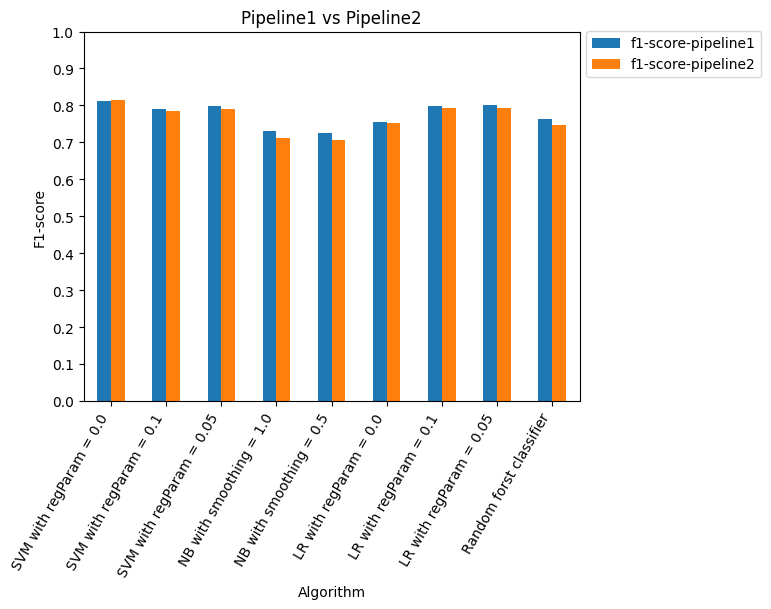

In [78]:
final_df['algorithm'] = final_df['algorithm'].str.replace('Naive bayes','NB')
final_df['algorithm'] = final_df['algorithm'].str.replace('LogisticRegression','LR')
plot1 = final_df.plot(x='algorithm', y=['f1-score-pipeline1','f1-score-pipeline2'], kind='bar')
plot1.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
ticks_loc = np.arange(0, 1.1, step=0.1)
plot1.set_yticks(ticks_loc)
plt.xticks(rotation=60, ha='right')
plt.title("Pipeline1 vs Pipeline2")
plt.xlabel("Algorithm")
plt.ylabel("F1-score")

Text(0, 0.5, 'F1-score')

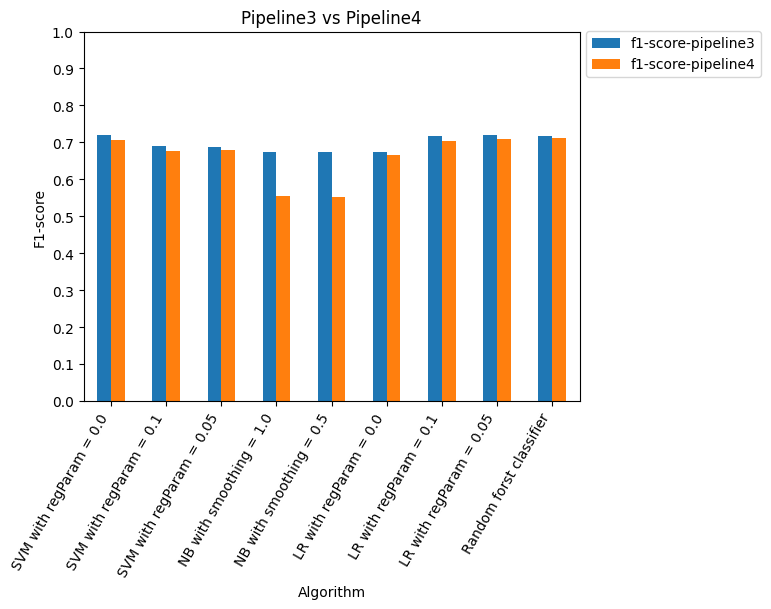

In [79]:
final_df['algorithm'] = final_df['algorithm'].str.replace('Naive bayes','NB')
final_df['algorithm'] = final_df['algorithm'].str.replace('LogisticRegression','LR')
plot1 = final_df.plot(x='algorithm', y=['f1-score-pipeline3','f1-score-pipeline4'], kind='bar')
plot1.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
ticks_loc = np.arange(0, 1.1, step=0.1)
plot1.set_yticks(ticks_loc)
plt.xticks(rotation=60, ha='right')
plt.title("Pipeline3 vs Pipeline4")
plt.xlabel("Algorithm")
plt.ylabel("F1-score")

Text(0, 0.5, 'F1-score')

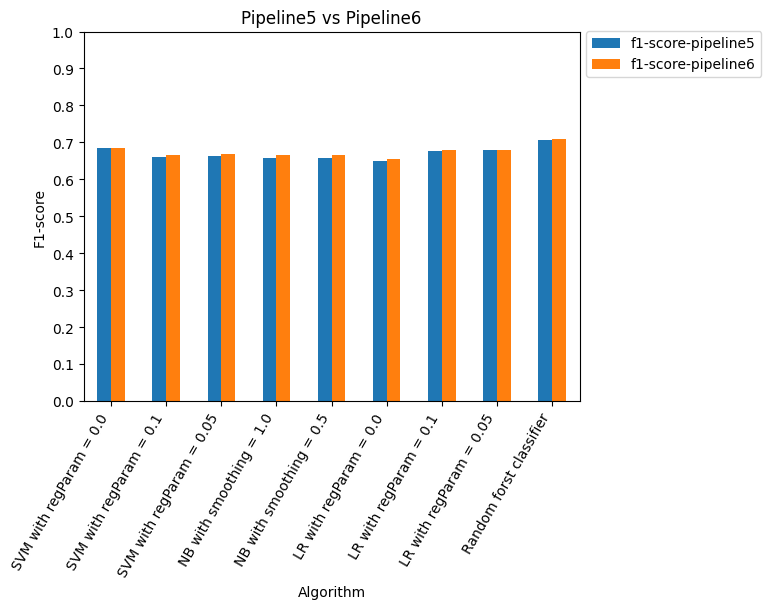

In [83]:
final_df['algorithm'] = final_df['algorithm'].str.replace('Naive bayes','NB')
final_df['algorithm'] = final_df['algorithm'].str.replace('LogisticRegression','LR')
plot1 = final_df.plot(x='algorithm', y=['f1-score-pipeline5','f1-score-pipeline6'], kind='bar')
plot1.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
ticks_loc = np.arange(0, 1.1, step=0.1)
plot1.set_yticks(ticks_loc)
plt.xticks(rotation=60, ha='right')
plt.title("Pipeline5 vs Pipeline6")
plt.xlabel("Algorithm")
plt.ylabel("F1-score")